<a href="https://colab.research.google.com/github/aryatomarAI/Machine-learning-and-data-science/blob/main/Deep-Learning-plus-Project/Dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐕‍🦺 Using Tensorflow 2.0 and Transfer learning to classify different dog breeds
This notebook builds an end-to-end multi-class image classifier using Tensorflow and Tensorflow Hub

We're using Kaggle Dog Identification competition
## 1. Problem
   Identifying the breed of a dog given an image of a dog.
## 2. Data
   The data we're using is from [Kaggle's dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/data)
## 3. Evaluation
   The evaluation is a file with prediction probabilities for each dog breed of each test image.

   [Evaluated on Multi Class Log Loss between the predicted probability and the observed target](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation)

## 4. Features

Some Information about the data:

We're dealing with images (Unstructured data).
It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.




## Get our Workspace ready

In [1]:
# Import Tensorflow into colab
import tensorflow as tf
print("We are using Tensor flow version",tf.__version__)

We are using Tensor flow version 2.4.1


In [2]:
# Importing Tensflow_hub and checking for GPU 
import tensorflow_hub as hub
print("Tensorflow hub version:",hub.__version__)

print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

Tensorflow hub version: 0.12.0
GPU available


## Loading our data lables
**Getting our data ready(turning into tensors)**

With all machine learning models our data has to be in numerical format, So we have turn our images into tensors(numerical representations)


In [4]:
# Let's check our labels first
import pandas as pd

im_labels=pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
im_labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,f8e931fdc022ea586f2bcd50ca6de106,scottish_deerhound
freq,1,126


In [7]:
im_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


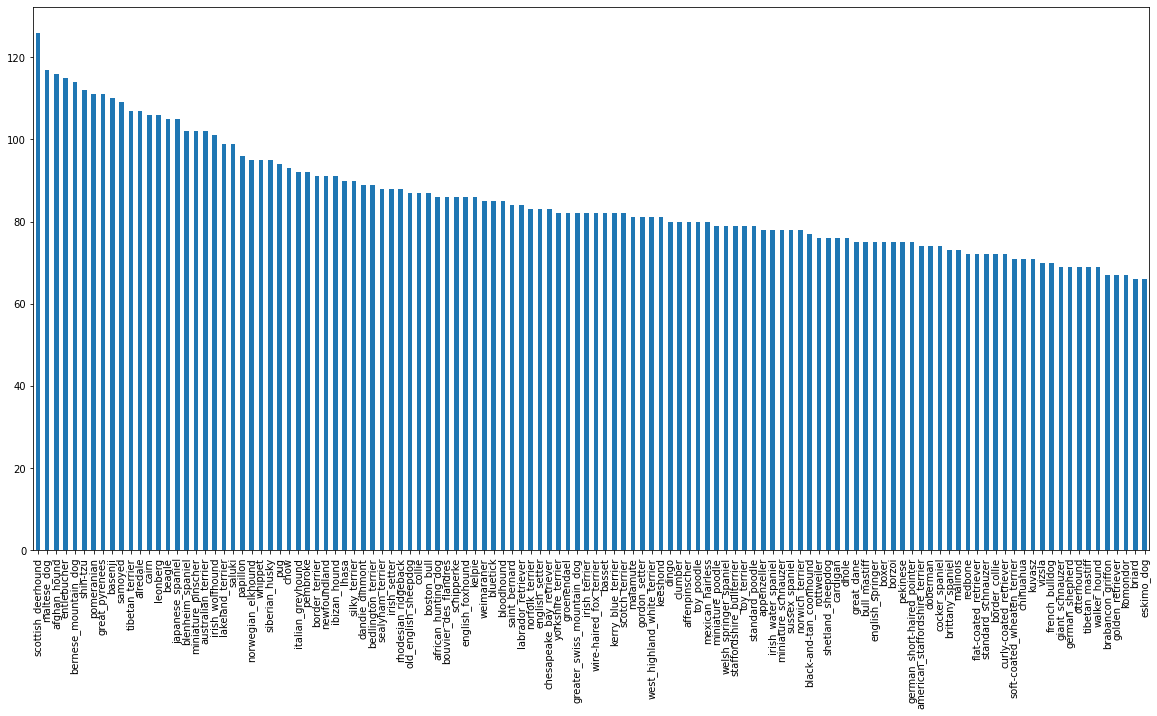

In [7]:
# How many images are there of each breed
im_labels["breed"].value_counts().plot(kind='bar',figsize=(20,10))

## Preparing the Images 

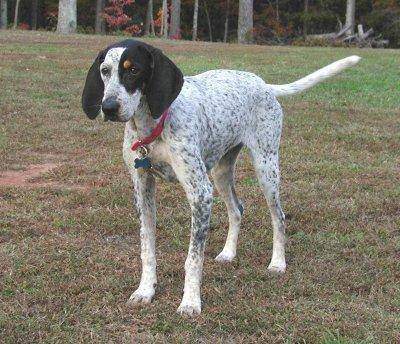

In [5]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`im_labels`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [6]:
# Create pathnames from image ids
filename=['drive/MyDrive/Dog Vision/train/' + fname + ".jpg" for fname in im_labels["id"]]

filename[:20]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'drive/MyDrive/Dog Vision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'drive/MyDrive/Dog Vision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'drive/MyDrive/Dog Vision/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'drive/MyDrive/Dog Vision/train/006cc3ddb9dc1bd827479569fcdc52d

In [7]:
# check whether number of filenames matches number of actual image files in train folder 
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/"))==len(filename):
  print("Filename match actual amount of files!!!")
else:
  print("Oops your filename doesn't match actual amount of files")

Filename match actual amount of files!!!


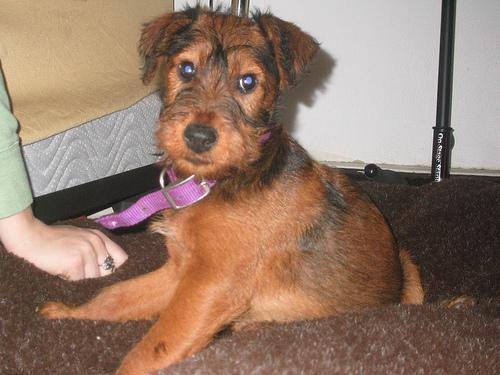

In [8]:
Image(filename[120])


In [9]:
im_labels["breed"][120] # breed of above the dog in above image

'irish_terrier'

In [11]:
# turn labels into numpy array
import numpy as np
dog_labels=im_labels['breed'].to_numpy()
dog_labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [12]:
# check if dog_labels have same amount of items as filename
if len(dog_labels)==len(filename):
  print("length Match")
else:
  print("Length Doesn't match, please check your data directory")

length Match


Since machine learning models can't take strings as input we've to convert our string array into numbers

To begin with, we'll find all the unique dog breed names inside the dog_labels array

Then we'll go through the list of label's and compare them to unique breed and create a list of booleans indicating 
which one is the real label(`True`) and which one is the false label (`False`)


In [13]:
#  find the unique labels values
unique_breeds=np.unique(dog_labels)
len(unique_breeds) 

120

In [14]:
# So as we know we have 120 dog breeds into our data 
# Now turn a single label into an array of booleans
print(dog_labels[0])
dog_labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
# now turn every dog_label into boolean array
boolean_labels=[label==unique_breeds for label in dog_labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [16]:
len(boolean_labels)

10222

In [17]:
# Turning our boolean array into integers, how?
# let's see an example
print(dog_labels[0])   # Our dog breed
print(np.where(unique_breeds==dog_labels[0]))  #index where label occurs
print(boolean_labels[0].argmax())              #index where label occurs in boolean array
print(boolean_labels[0].astype(int))           # there will be a 1 where the our dog label occurs 


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
